# Uncertainty Quantification

This is a tutorial for the uncertainty quantification package in CLIMADA.

## Uncertainty and sensitivity analysis?

Before doing an uncertainty quantification in CLIMADA, it is imperative that you get first comfortable with the different notions of uncertainty in the modelling world (see e.g. [Douglas-Smith(2020)](https://doi.org/10.1007/978-1-4899-7547-8_5) for a review). In particular, note that the uncertaintity values will only be as good as the input from the user. In addition, not all uncertainties can be numerically quantified, and even worse, some unkonwns are unknown. This means that sometimes, quantifying uncertainty can lead to false confidence in the output!. For a more philosophical discussion about the types of uncertainties in climate research see [Knüsel2020](https://www.research-collection.ethz.ch/handle/20.500.11850/399735).

In this module, it is possible to perform global uncertainty analysis, as well as a sensitivity analysis. The word global is meant as opposition to the 'one-factor-at-a-time' (OAT) strategy. The OAT strategy, which consists in analyzing the effect of varying one model input factor at a time while keeping all other fixed, is popular among modellers, but has major shortcomings [Saltelli (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180), [Saltelli(2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822) and should not be used.

A rough schemata of how to perform uncertainty and sensitivity analysis (taken from [Saltelli(2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822))

<img src="./img/UncertaintySensitivity.jpg" alt="Uncertainty and Sensitivity analysis" width="600">

1. [Douglas-Smith, D., Iwanaga, T., Croke, B. F. W. & Jakeman, A. J. Certain trends in uncertainty and sensitivity analysis: An overview of software tools and techniques. Environmental Modelling & Software 124, 104588 (2020)](https://doi.org/10.1007/978-1-4899-7547-8_5)
2. [Knüsel, B. Epistemological Issues in Data-Driven Modeling in Climate Research. (ETH Zurich, 2020)](https://www.research-collection.ethz.ch/handle/20.500.11850/399735)
3. [Saltelli, A. et al. Why so many published sensitivity analyses are false: A systematic review of sensitivity analysis practices. Environmental Modelling & Software 114, 29–39 (2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822)
4. [Saltelli, A. & Annoni, P. How to avoid a perfunctory sensitivity analysis. Environmental Modelling & Software 25, 1508–1517 (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180)

##  Uncertainty Quantification Package Structure

The uncertainty package contains several key classes. 

The model input parameters and their distribution are specified as
- `InputVar`: defines input uncertainty variables

The input parameter sampling, Monte-Carlo uncertainty distribution calculation and the sensitivity index computation are done in
- `CalcImpact`: compute uncertainties for outputs of `climada.engine.impact.calc` (child class of `Calc`)
- `CalcCostBenefit`: compute uncertainties for outputs of `climada.engine.cost_benefit.calc` (child class of `Calc`)

The results are stored in
- `UncOutput`: store the uncertainty and sensitivity analysis results. Contains also several plotting methods. This is a class which only stores data.

## InputVar 

The InputVar class is used to define uncertainty variables. 

| Attribute | Type | Description |
| --- | --- | --- |
| func | function | Model variable defined as a function of the uncertainty input parameters |
| distr_dict | dict | Dictionary of the probability density distributions of the uncertainty input parameters |

An **input uncertainty parameter** is a numerical input value that has a certain probability density distribution in your model, such as the total exposure asset value, the slope of the vulnerability function, the exponents of the litpop exposure,  the value of the discount rate, the cost of an adaptation measure, ... 

The probability densitity distributions (values of `distr_dict`) of the input uncertainty parameters (keyword arguments of the `func` and keys of the `distr_dict`) can be any of the ones defined in [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

 **Several helper methods exist to make generic InputVar for Exposures, ImpactFuncSet, Hazard, Entity (including DiscRates and Measures)**. These are described in details in section [InputVar - built-in methods](#InputVar---built-in-methods) at the end of this tutorial.

### Example - custom continuous uncertainty parameter

Suppose we assume that the GDP value used to scale the exposure has a relative error of +-10%. 

In [17]:
#Define the base exposure
from climada.util.constants import EXP_DEMO_H5
from climada.entity import Exposures
exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)

2021-08-23 19:27:06,919 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5


In [18]:
# Define the function that returns an exposure with scaled total assed value
# Here x_exp is the input uncertainty parameter and exp_func the inputvar.func.
def exp_func(x_exp, exp_base=exp_base):
    exp = exp_base.copy()
    exp.gdf.value *= x_exp
    return exp

In [19]:
# Define the Uncertainty Variable with +-10% total asset value
# The probability density distribution of the input uncertainty parameter x_exp is sp.stats.uniform(0.9, 0.2)
from climada.engine.uncertainty_quantification import InputVar
import scipy as sp

exp_distr = {"x_exp": sp.stats.uniform(0.9, 0.2),
              }
exp_iv = InputVar(exp_func, exp_distr)

In [20]:
# Uncertainty parameters
exp_iv.labels

['x_exp']

In [21]:
# Evaluate for a given value of the uncertainty parameters
exp095 = exp_iv.func(x_exp = 0.95)
print(f"Base value is {exp_base.gdf['value'].sum()}, and the value for x_exp=0.95 is {exp095.gdf['value'].sum()}")

Base value is 657053294559.9105, and the value for x_exp=0.95 is 624200629831.9148


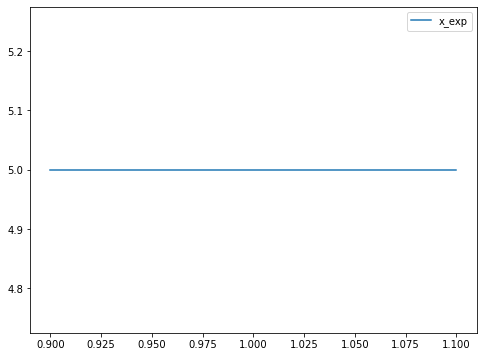

In [22]:
# Defined distribution
exp_iv.plot(figsize=(8, 6));

### Example - custom categorical uncertainty parameter 

Suppose we want to test different exponents (m=0,1,2 ; n=0,1,2) for the LitPop exposure for the country Switzerland.

In [23]:
from climada.entity import LitPop

m_min, m_max = (0, 2)
n_min, n_max = (0, 2)

# Define the function
# Note that this here works, but might be slow because the method LitPop is called everytime the the function
# is evaluated, and LitPop is relatively slow. 
def litpop_cat(m, n):
    exp = Litpop()
    exp.set_country('CHE', exponent=[m, n])
    return exp

In [24]:
# A faster method would be to first create a dictionnary with all the exposures. This however
# requires more memory and precomputation time (here ~3-4mins)
exp = LitPop()
litpop_dict = {}
for m in range(m_min, m_max + 1):
    for n in range(n_min, n_max + 1):
        exp_mn = exp.copy()
        exp_mn.set_country('CHE', exponents=[m, n])
        litpop_dict[(m, n)] = exp_mn
        
def litpop_cat(m, n, litpop_dict=litpop_dict):
    return litpop_dict[(m, n)]

2021-08-23 19:27:07,384 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CHE (756)...

2021-08-23 19:27:07,386 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2021-08-23 19:27:07,388 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2021-08-23 19:27:07,584 - climada.entity.exposures.litpop.nightlight - DEBUG - Found all required satellite data (1 files) in folder /Users/ckropf/climada/data
2021-08-23 19:27:07,585 - climada.entity.exposures.litpop.nightlight - DEBUG - All required files already exist. No downloads necessary.
2021-08-23 19:27:11,253 - climada.util.finance - INFO - GDP CHE 2014: 7.344e+11.
2021-08-23 19:27:11,684 - climada.util.finance - INFO - GDP CHE 2018: 7.359e+11.
2021-08-23 19:27:11,738 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2021-08-23 19:27:11,738 - climada.entity.exposures.base - INFO - ca

2021-08-23 19:27:37,480 - climada.util.finance - INFO - GDP CHE 2014: 7.344e+11.
2021-08-23 19:27:37,909 - climada.util.finance - INFO - GDP CHE 2018: 7.359e+11.
2021-08-23 19:27:37,961 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2021-08-23 19:27:37,962 - climada.entity.exposures.base - INFO - category_id not set.
2021-08-23 19:27:37,962 - climada.entity.exposures.base - INFO - cover not set.
2021-08-23 19:27:37,963 - climada.entity.exposures.base - INFO - deductible not set.
2021-08-23 19:27:37,963 - climada.entity.exposures.base - INFO - centr_ not set.
2021-08-23 19:27:38,190 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CHE (756)...

2021-08-23 19:27:38,191 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2021-08-23 19:27:38,192 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2021-08-23 19:27:38,356 - climad

In [25]:
#Define the distribution dictionnary
import scipy as sp
from climada.engine.uncertainty_quantification import InputVar

distr_dict = {
    'm': sp.stats.randint(low=m_min, high=m_max+1),
    'n': sp.stats.randint(low=n_min, high=n_max+1)
    }

cat_iv = InputVar(litpop_cat, distr_dict) # One can use either of the above definitions of litpop_cat

In [26]:
# Uncertainty parameters
cat_iv.labels

['m', 'n']

In [27]:
cat_iv.evaluate(m=1, n=1).value_unit

'USD'

## UncOutput 

##  CalcImpact

### Set the InputVars 

In this example, we model the impact function for tropical cyclones on the parametric function suggested in Emanuel (2015) with 4 parameters. The exposures total value varies between 80% and 120%. For that hazard, we assume to have no good error estimate and thus do not define an InputVar for the hazard.

In [1]:
#Define the input variable functions
import numpy as np

from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5
from climada.hazard import Hazard

def impf_func(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):    
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'TC'
    imp_fun.id = _id
    imp_fun.intensity_unit = 'm/s'
    imp_fun.intensity = np.linspace(0, 150, num=100)
    imp_fun.mdd = np.repeat(1, len(imp_fun.intensity))
    imp_fun.paa = np.array([sigmoid_func(v, G, v_half, vmin, k) for v in imp_fun.intensity])
    imp_fun.check()
    impf_set = ImpactFuncSet()
    impf_set.append(imp_fun)
    return impf_set

def xhi(v, v_half, vmin):
    return max([(v - vmin), 0]) / (v_half - vmin)
  
def sigmoid_func(v, G, v_half, vmin, k):
    return G * xhi(v, v_half, vmin)**k / (1 + xhi(v, v_half, vmin)**k)

haz = Hazard()
haz.read_hdf5(HAZ_DEMO_H5)

exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)
#It is a good idea to assign the centroids to the base exposures in order to avoid repeating this
# potentially costly operation for each sample.
exp_base.assign_centroids(haz) 

def exp_func(x_exp, exp_base=exp_base):
    exp = exp_base.copy()
    exp.gdf.value *= x_exp
    return exp


2021-08-24 11:01:24,918 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5
2021-08-24 11:01:24,982 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2021-08-24 11:01:25,161 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-08-24 11:01:25,172 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100


/Users/ckropf/opt/anaconda3/envs/climada_220/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2021-08-24 11:01:25,184 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


<AxesSubplot:title={'center':'TC 1: '}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

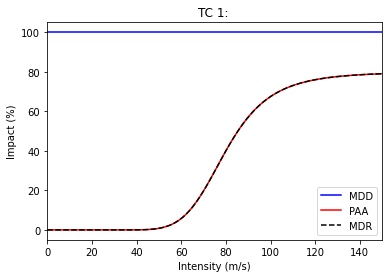

In [2]:
# Visualization of the parametrized impact function
impf_func(G=0.8, v_half=80, vmin=30,k=5).plot()

In [3]:
#Define the InputVars

import scipy as sp
from climada.engine.uncertainty_quantification import InputVar

exp_distr = {"x_exp": sp.stats.beta(10, 1.1)} #This is not really a reasonable distribution but is used 
                                              #here to show that you can use any scipy distribution.
              
exp_iv = InputVar(exp_func, exp_distr)

impf_distr = {
    "G": sp.stats.truncnorm(0.5, 1.5),
    "v_half": sp.stats.uniform(35, 65),
    "vmin": sp.stats.uniform(0, 15),
    "k": sp.stats.uniform(1, 4)
    }
impf_iv = InputVar(impf_func, impf_distr)

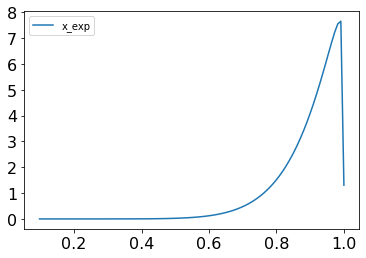

In [4]:
import matplotlib.pyplot as plt
ax = exp_iv.plot(figsize=(6,4));
plt.yticks(fontsize=16);
plt.xticks(fontsize=16);

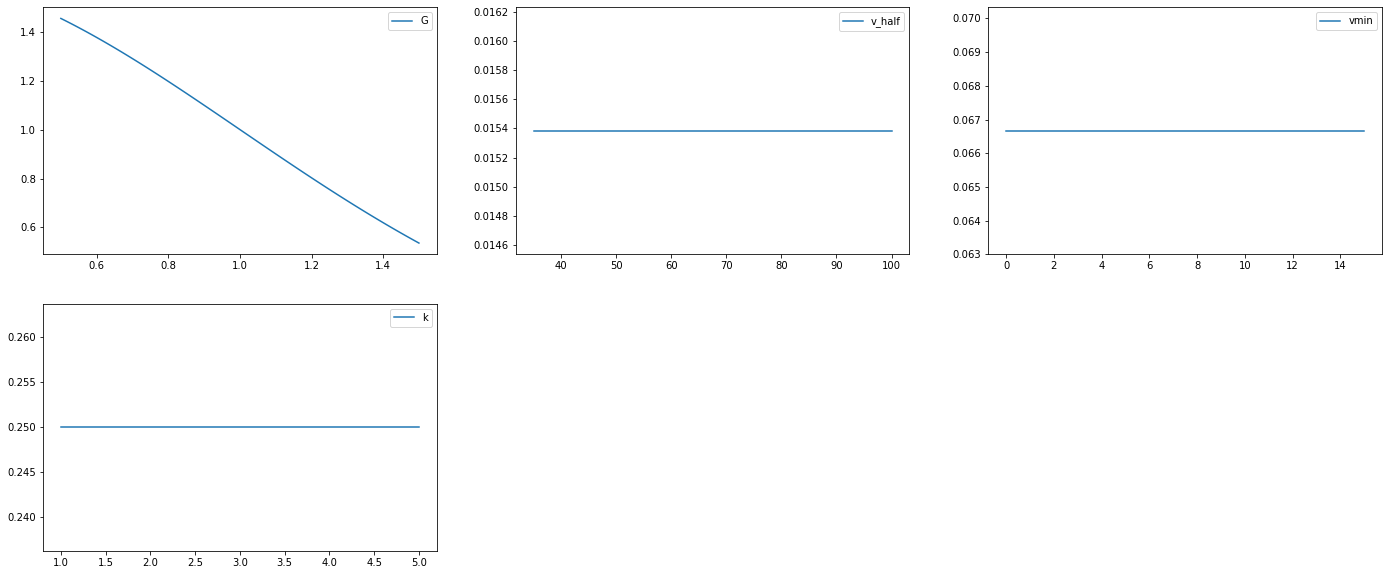

In [5]:
impf_iv.plot();

### Compute uncertainty and sensitivity using default methods 

First, we define the UncImpact object with our uncertainty variables. 

In [6]:
from climada.engine.uncertainty_quantification import CalcImpact

calc_imp = CalcImpact(exp_iv, impf_iv, haz)

Next, we generate samples for the uncertainty parameters using the default methods. Note that depending on the chosen Salib method, the effective number of samples differs from the input variable N. For the default 'saltelli', with `calc_second_order=True`, the effective number is N(2D+2), with D the number of uncertainty parameters. See [SAlib](https://salib.readthedocs.io/en/latest/api.html) for more information.

In [7]:
output_imp = calc_imp.make_sample(N=2**7, sampling_kwargs={'skip_values': 2**8})
output_imp.samples_df

2021-08-24 11:01:34,351 - climada.engine.uncertainty_quantification.calc_base - INFO - Effective number of made samples: 1536


,x_exp,G,v_half,vmin,k
0,0.585742,0.884755,79.052734,4.423828,4.117188
1,0.787526,0.884755,79.052734,4.423828,4.117188
2,0.585742,0.771351,79.052734,4.423828,4.117188
3,0.585742,0.884755,58.232422,4.423828,4.117188
4,0.585742,0.884755,79.052734,4.306641,4.117188
...,...,...,...,...,...
1531,0.876684,1.242977,53.662109,2.080078,4.539062
1532,0.876684,0.790617,44.013672,2.080078,4.539062
1533,0.876684,0.790617,53.662109,13.681641,4.539062
1534,0.876684,0.790617,53.662109,2.080078,3.960938


The resulting samples can be visualized in plots.

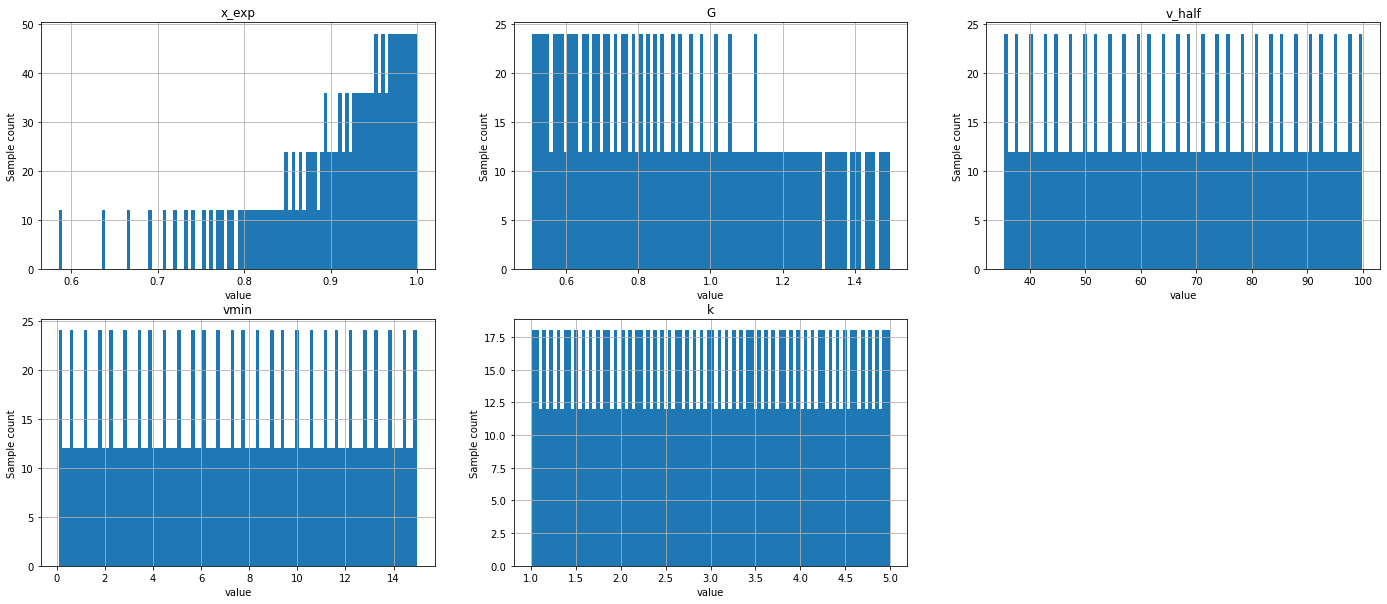

In [8]:
output_imp.plot_sample();

Now we can compute the value of the impact metrics for all the samples. In this example, we additionaly chose to restrict the return periods 50, 100, and 250 years. By default, `eai_exp` and `at_event` are not stored.

In [9]:
output_imp = calc_imp.uncertainty(output_imp, rp = [50, 100, 250])

2021-08-24 11:01:39,876 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:01:39,878 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:01:39,880 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:01:39,885 - climada.engine.uncertainty_quantification.calc_base - INFO - 

Estimated computaion time: 0:00:23.961600



/Users/ckropf/Documents/Climada/climada_python/climada/engine/uncertainty_quantification/calc_impact.py:211: RuntimeWarning: invalid value encountered in long_scalars
  if np.count_nonzero(df_eai_exp.to_numpy()) / df_eai_exp.size < 0.5:
/Users/ckropf/Documents/Climada/climada_python/climada/engine/uncertainty_quantification/calc_impact.py:215: RuntimeWarning: invalid value encountered in long_scalars
  if np.count_nonzero(df_at_event.to_numpy()) / df_at_event.size < 0.5:


The distributions of metrics ouputs are stored as dictionaries of pandas dataframe. The metrics are directly taken from the output of `climada.impact.calc`. For each metric, on dataframe is made.

In [10]:
#All the computed uncertainty metrics attribute
output_imp.uncertainty_metrics

['aai_agg_unc_df', 'freq_curve_unc_df', 'tot_value_unc_df']

In [11]:
#One uncertainty dataframe
output_imp.aai_agg_unc_df

,aai_agg
0,3.118263e+08
1,4.192481e+08
2,2.718581e+08
3,1.072144e+09
4,3.143573e+08
...,...
1531,2.905571e+09
1532,3.755172e+09
1533,1.063119e+09
1534,2.248718e+09


Accessing the uncertainty is in general done via the method `get_uncertainty()`. If none are specified, all metrics are returned.

In [12]:
output_imp.get_uncertainty()

,aai_agg,rp50,rp100,rp250,tot_value
0,3.118263e+08,8.810373e+09,1.263780e+10,1.692579e+10,3.848640e+11
1,4.192481e+08,1.184548e+10,1.699143e+10,2.275659e+10,5.174467e+11
2,2.718581e+08,7.681107e+09,1.101796e+10,1.475633e+10,3.848640e+11
3,1.072144e+09,3.068216e+10,4.298860e+10,5.608824e+10,3.848640e+11
4,3.143573e+08,8.883157e+09,1.272773e+10,1.703087e+10,3.848640e+11
...,...,...,...,...,...
1531,2.905571e+09,8.324391e+10,1.162643e+11,1.510689e+11,5.760281e+11
1532,3.755172e+09,1.096005e+11,1.460838e+11,1.809413e+11,5.760281e+11
1533,1.063119e+09,2.892734e+10,4.720869e+10,6.807561e+10,5.760281e+11
1534,2.248718e+09,6.468855e+10,8.653474e+10,1.085266e+11,5.760281e+11


The distributions of the one-dimensioanl metrics (`eai_exp` and `at_event` are never shown with this method) can be vizualised with plots.

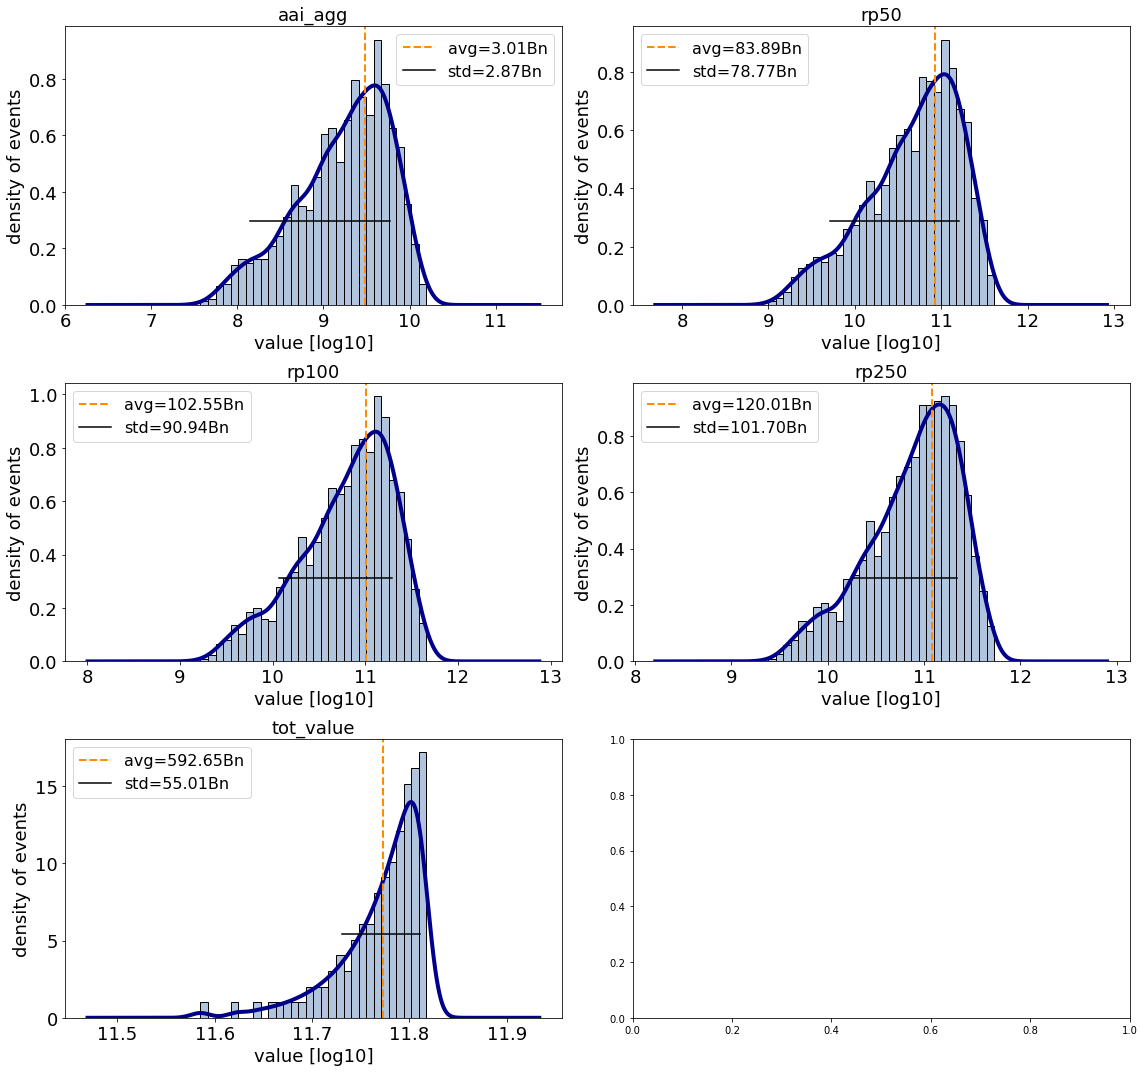

In [13]:
output_imp.plot_uncertainty(log=True);

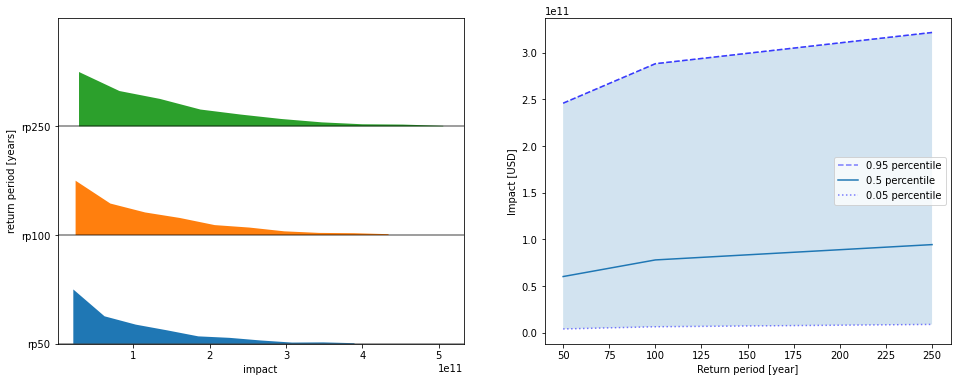

In [14]:
# Specific plot for the return period distributions
output_imp.plot_rp_uncertainty();

Now that a distribution of the impact metrics has been computed for each sample, we can also compute the sensitivity indices for each metrics to each uncertainty parameter. Note that the chosen method for the sensitivity analysis should correpond to its sampling partner as defined in the [SAlib](https://salib.readthedocs.io/en/latest/api.html) package.

The sensitivity indices dictionnaries outputs from the SAlib methods are stored in the same structure of nested dictionnaries as the metrics distributions. Note that depending on the chosen sensitivity analysis method the returned indices dictionnary will return specific types of sensitivity indices with specific names. Please get familiar with [SAlib](https://salib.readthedocs.io/en/latest/api.html) for more information.

Note that in our case, several of the second order sensitivity indices are negative. For the default method `sobol`, this indicates that the algorithm has not converged and cannot give realiable values for these sensitivity indices. If this happens, please use a larger number of samples. Here we will focus on the first-order indices.

In [15]:
output_imp = calc_imp.sensitivity(output_imp)

Similarly to the uncertainty case, the data is stored in dataframe attributes.

In [16]:
output_imp.sensitivity_metrics

['aai_agg_sens_df', 'freq_curve_sens_df', 'tot_value_sens_df']

In [17]:
output_imp.aai_agg_sens_df

,si,param,param2,aai_agg
0,S1,x_exp,None,0.001040
1,S1,G,None,0.073408
2,S1,v_half,None,0.514220
3,S1,vmin,None,0.012642
4,S1,k,None,0.213491
...,...,...,...,...
65,S2_conf,k,x_exp,NaN
66,S2_conf,k,G,NaN
67,S2_conf,k,v_half,NaN
68,S2_conf,k,vmin,NaN


To obtain the sensitivity interms of a particular sensitivity index, use the method `get_sensisitivity()`. If none is specified, the value of the index for all metrics is returned.

In [18]:
output_imp.get_sensitivity('S1')

,si,param,param2,aai_agg,rp50,rp100,rp250,tot_value
0,S1,x_exp,None,0.001040,0.000993,0.000930,0.001150,1.005253
1,S1,G,None,0.073408,0.075781,0.084662,0.093718,0.000000
2,S1,v_half,None,0.514220,0.553640,0.596659,0.619366,0.000000
3,S1,vmin,None,0.012642,0.014407,0.012068,0.010065,0.000000
4,S1,k,None,0.213491,0.189862,0.134867,0.095861,0.000000


The value of the sensitivity indices can be plotted for each metric that is one-dimensional (`eai_exp` and `at_event` are not shown in this plot). 

As expected, the `tot_value` of the exposure is only dependent on the exposure parameter `x_exp`. We further see that both the errors in `freq_curve` and in `aai_agg` are mostly determined by `x_exp` and `v_half`. Finally, we see small differences in the sensitivity of the different return periods.

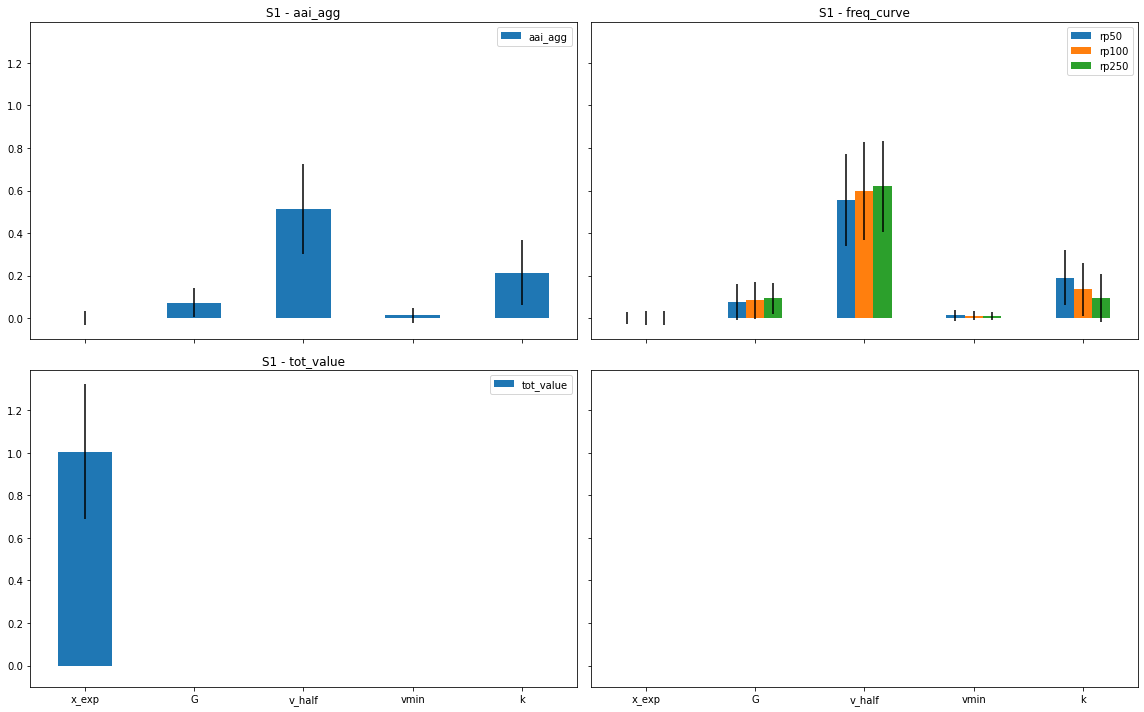

In [19]:
# Default for 'sobol' is to plot 'S1' sensitivity index.
output_imp.plot_sensitivity();

Note that since we have quite a few measures, the imp_meas_fut and imp_meas_pres plots are too crowded. We can select only the other metrics easily. In addition, instead of showing first order sensitivity 'S1', we can plot the total sensitivity 'ST'.

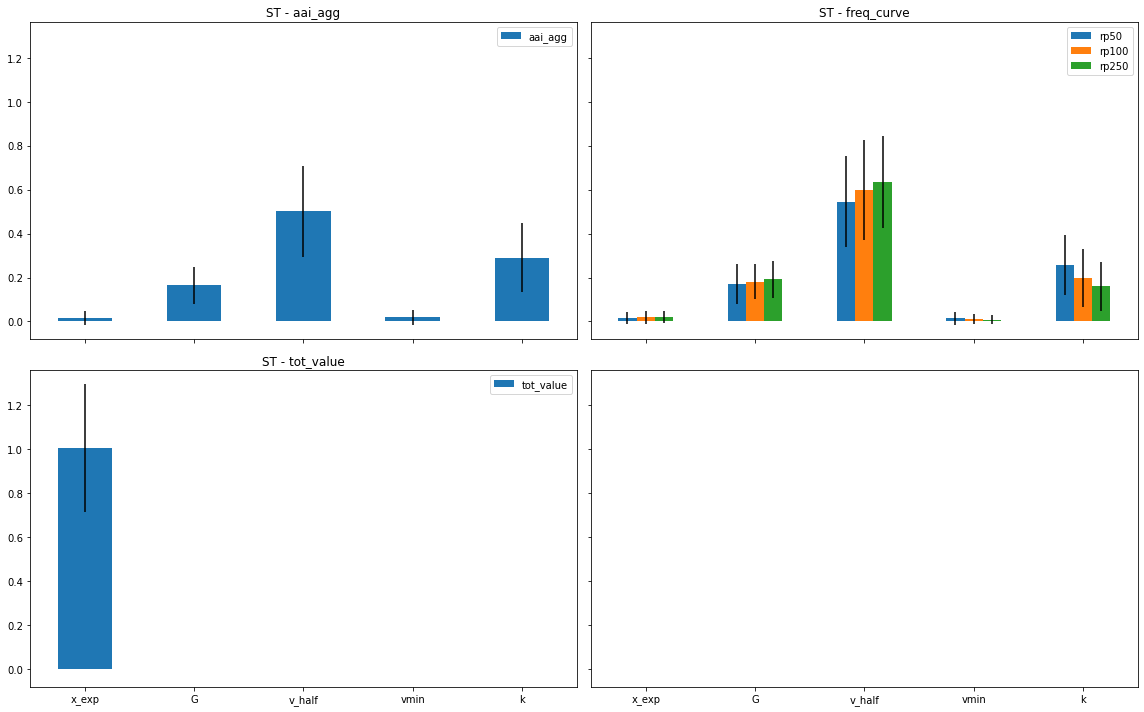

In [22]:
output_imp.plot_sensitivity(salib_si = 'ST');

One can also vizualise the second-order sensitivity indices in the form of a correlation matrix.

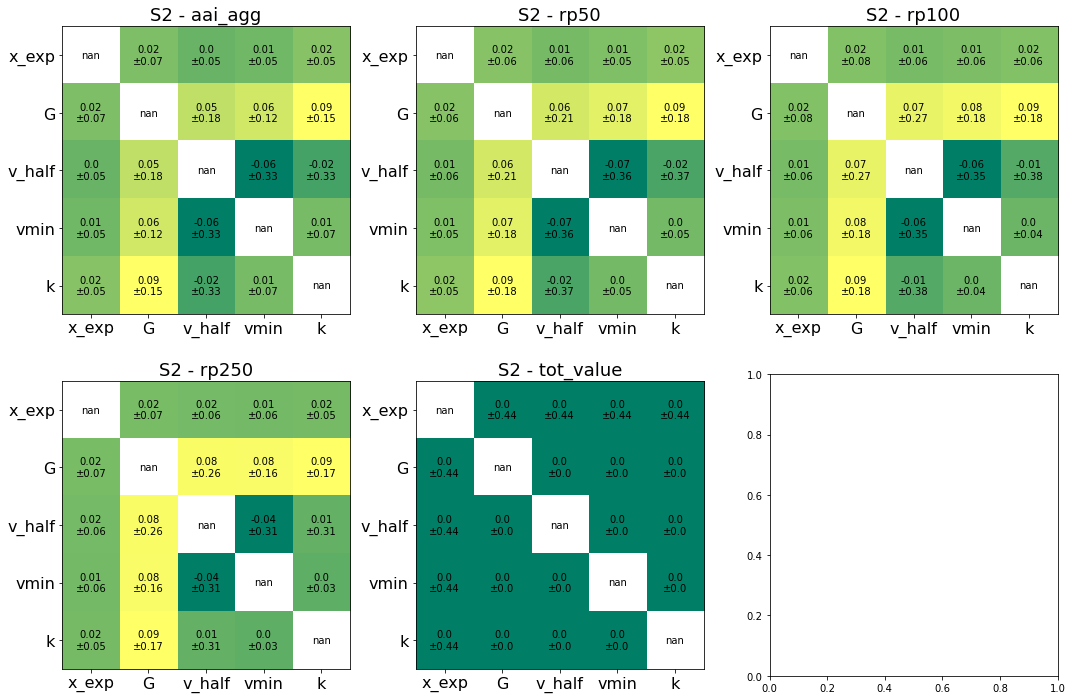

In [20]:
output_imp.plot_sensitivity_second_order();

### A few non-default parameters

We shall use the same uncertainty variables as in the previous section but show a few possibilities to use non-default method arguments.

In [21]:
# Sampling method "latin" hypercube instead of `saltelli`.
from climada.engine.uncertainty_quantification import CalcImpact

calc_imp2 = CalcImpact(exp_iv, impf_iv, haz)
output_imp2 = calc_imp2.make_sample(N=1000, sampling_method='latin')

2021-08-24 11:02:10,149 - climada.engine.uncertainty_quantification.calc_base - INFO - Effective number of made samples: 1000


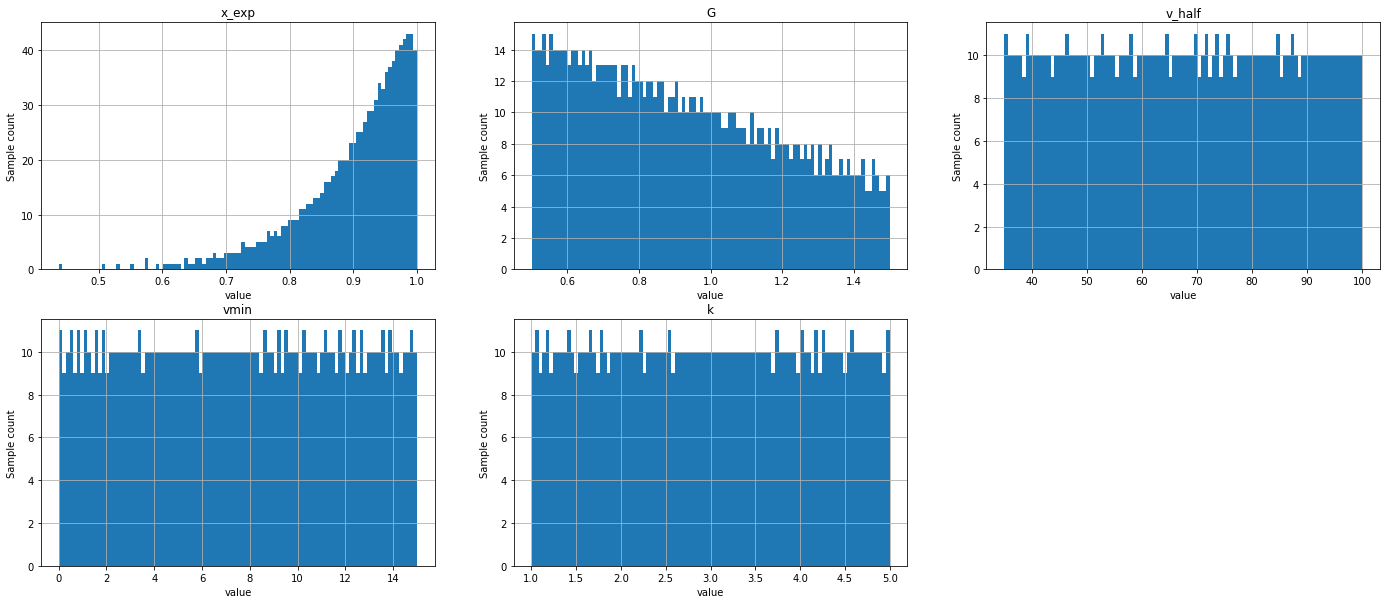

In [23]:
output_imp2.plot_sample();

In [24]:
# Compute also the distribution of the metric `eai_exp`
# To speed-up the comutations, we use a ProcessPool for parallel computations
from pathos.pools import ProcessPool as Pool
pool = Pool()
output_imp2 = calc_imp2.uncertainty(output_imp2, rp = [50, 100, 250], calc_eai_exp=True, calc_at_event=True, pool=pool)
pool.close() #Do not forget to close your pool!
pool.join()
pool.clear()

2021-08-24 11:02:15,217 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:15,220 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,222 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,228 - climada.engine.uncertainty_quantification.calc_base - INFO - 

Estimated computaion time: 0:00:03.437500



/Users/ckropf/opt/anaconda3/envs/climada_220/lib/python3.8/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/Users/ckropf/opt/anaconda3/envs/climada_220/lib/python3.8/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-08-24 11:02:15,357 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


/Users/ckropf/opt/anaconda3/envs/climada_220/lib/python3.8/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-08-24 11:02:15,361 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,364 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,378 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


/Users/ckropf/opt/anaconda3/envs/climada_220/lib/python3.8/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-08-24 11:02:15,382 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,385 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:15,386 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,389 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,392 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,400 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:15,427 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 

/Users/ckropf/opt/anaconda3/envs/climada_220/lib/python3.8/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-08-24 11:02:15,422 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,423 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,437 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:15,445 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:15,452 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,453 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,455 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting

/Users/ckropf/opt/anaconda3/envs/climada_220/lib/python3.8/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-08-24 11:02:15,462 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,475 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:15,479 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:15,482 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,491 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,493 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,495 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 

/Users/ckropf/opt/anaconda3/envs/climada_220/lib/python3.8/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-08-24 11:02:15,512 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


/Users/ckropf/opt/anaconda3/envs/climada_220/lib/python3.8/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-08-24 11:02:15,539 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:15,518 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,542 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,545 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,546 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:15,546 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,548 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:1

2021-08-24 11:02:15,664 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,668 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,669 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,669 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,672 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:15,672 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,674 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,672 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,

2021-08-24 11:02:15,751 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:15,751 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,751 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,754 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,754 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,755 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,756 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,758 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,758 - c

2021-08-24 11:02:15,845 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,845 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,846 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,846 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,849 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,850 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,861 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:15,863 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shi

2021-08-24 11:02:15,942 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:15,939 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,945 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,944 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:15,949 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:15,950 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:15,952 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 

2021-08-24 11:02:16,045 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,042 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,048 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,048 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,048 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,049 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,051 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,052 - climad

2021-08-24 11:02:16,121 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,120 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,123 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,122 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,128 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,126 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,128 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:1

2021-08-24 11:02:16,223 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,223 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,228 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,230 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,232 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,233 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
20

2021-08-24 11:02:16,314 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,315 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,321 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,315 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,317 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,304 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,320 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:1

2021-08-24 11:02:16,424 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,427 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,428 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,430 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,431 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,432 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-2

2021-08-24 11:02:16,486 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,487 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,488 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,491 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,495 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,495 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,495 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting

2021-08-24 11:02:16,572 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,572 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,576 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,576 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,562 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,579 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,580 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-08-24 11:02:16,677 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,678 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,680 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,682 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,683 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,692 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,695 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 

2021-08-24 11:02:16,802 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,804 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,808 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,806 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,814 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,816 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-2

2021-08-24 11:02:16,917 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,919 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:16,919 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:16,919 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,920 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,924 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:16,923 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 

2021-08-24 11:02:17,038 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,029 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,019 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,043 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,045 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,049 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
20

2021-08-24 11:02:17,147 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,156 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,159 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,161 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,163 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,166 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,168 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,169 -

2021-08-24 11:02:17,255 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,254 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,250 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,256 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,259 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,260 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,247 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,266 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,265 - c

2021-08-24 11:02:17,356 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,362 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,363 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,362 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,368 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,369 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,369 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:1

2021-08-24 11:02:17,459 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,462 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,463 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,464 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,465 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,467 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02

2021-08-24 11:02:17,535 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,535 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,538 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,537 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,542 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,542 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,544 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:1

2021-08-24 11:02:17,641 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,642 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,643 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,646 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,646 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,645 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,647 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-08-24 11:02:17,734 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,745 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,748 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,748 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,752 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,754 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
20

2021-08-24 11:02:17,847 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,846 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,849 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,850 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,850 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,851 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,854 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 

2021-08-24 11:02:17,948 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:17,950 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,947 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,954 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:17,955 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:17,954 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-2

2021-08-24 11:02:18,054 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,058 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,058 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,059 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,061 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,063 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,064 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,065 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,

2021-08-24 11:02:18,163 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,168 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,171 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,170 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,175 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,177 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,179 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,180 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,

2021-08-24 11:02:18,302 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,303 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,304 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,316 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,323 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,321 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,328 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 

2021-08-24 11:02:18,433 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,434 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,438 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,439 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,439 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,443 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,447 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 

2021-08-24 11:02:18,535 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,537 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,539 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,539 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,541 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,540 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
20

2021-08-24 11:02:18,636 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,642 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,646 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,649 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,650 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,651 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-2

2021-08-24 11:02:18,735 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,736 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,743 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,746 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,746 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,748 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02

2021-08-24 11:02:18,856 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,858 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,860 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,856 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,860 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,858 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,864 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,866 -

2021-08-24 11:02:18,946 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,952 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:18,953 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,955 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,958 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:18,964 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:18,967 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021

2021-08-24 11:02:19,049 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,050 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,050 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,057 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,057 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,075 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
20

2021-08-24 11:02:19,188 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,187 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,188 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,195 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,196 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,198 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,198 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,199 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,202 - c

2021-08-24 11:02:19,298 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,296 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,299 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,299 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,302 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,303 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,304 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Con

2021-08-24 11:02:19,398 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,399 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,400 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,402 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,401 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,407 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,404 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021

2021-08-24 11:02:19,489 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,491 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,492 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,488 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,492 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,495 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,491 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 

2021-08-24 11:02:19,593 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,597 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,602 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,602 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,602 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,606 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,606 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:1

2021-08-24 11:02:19,726 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,721 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,726 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,726 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,731 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,733 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,742 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,742 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting t

2021-08-24 11:02:19,838 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,843 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:19,851 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,850 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,853 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,854 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
20

2021-08-24 11:02:19,953 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,954 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:19,958 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,954 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,954 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:19,958 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02

2021-08-24 11:02:20,023 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,026 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,027 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,028 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,030 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,030 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,027 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-08-24 11:02:20,130 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,141 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,141 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,145 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,146 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,146 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-2

2021-08-24 11:02:20,254 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,248 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,257 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,259 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,260 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,264 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,263 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-08-24 11:02:20,371 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,373 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,372 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,375 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,378 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,379 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,379 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,380 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,390 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin

2021-08-24 11:02:20,496 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,498 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,501 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,501 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,499 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,503 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-2

2021-08-24 11:02:20,597 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,607 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,610 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,612 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,617 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,619 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,621 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,625 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting t

2021-08-24 11:02:20,718 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,719 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,720 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,723 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,724 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,721 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,721 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:2

2021-08-24 11:02:20,848 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,850 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,848 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,852 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,849 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,856 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,855 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:2

2021-08-24 11:02:20,954 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,955 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,955 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,959 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:20,959 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:20,959 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:20,961 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-08-24 11:02:21,095 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:21,095 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:21,100 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:21,100 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-08-24 11:02:21,114 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:21,115 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-08-24 11:02:21,118 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-08-24 11:02:2

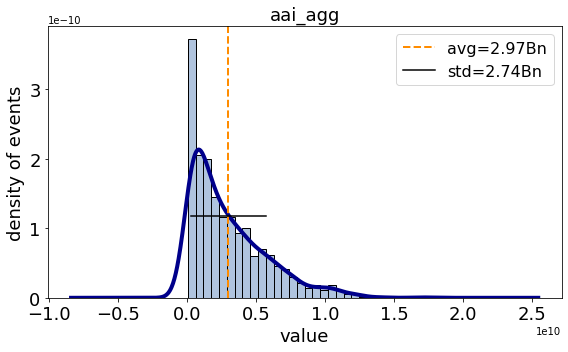

In [25]:
# plot the aai_agg distribution only
output_imp2.plot_uncertainty(metric_list=['aai_agg_unc_df']);

In [26]:
# Use the method 'rbd_fast' which is recommend in pair with 'latin'. In addition, change one of the kwargs 
# (M=15) of the salib sampling method.
output_imp2 = calc_imp.sensitivity(output_imp2, sensitivity_method='rbd_fast', sensitivity_kwargs = {'M': 15})

/Users/ckropf/opt/anaconda3/envs/climada_220/lib/python3.8/site-packages/SALib/analyze/rbd_fast.py:106: RuntimeWarning: invalid value encountered in double_scalars
  return D1 / V


/Users/ckropf/opt/anaconda3/envs/climada_220/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


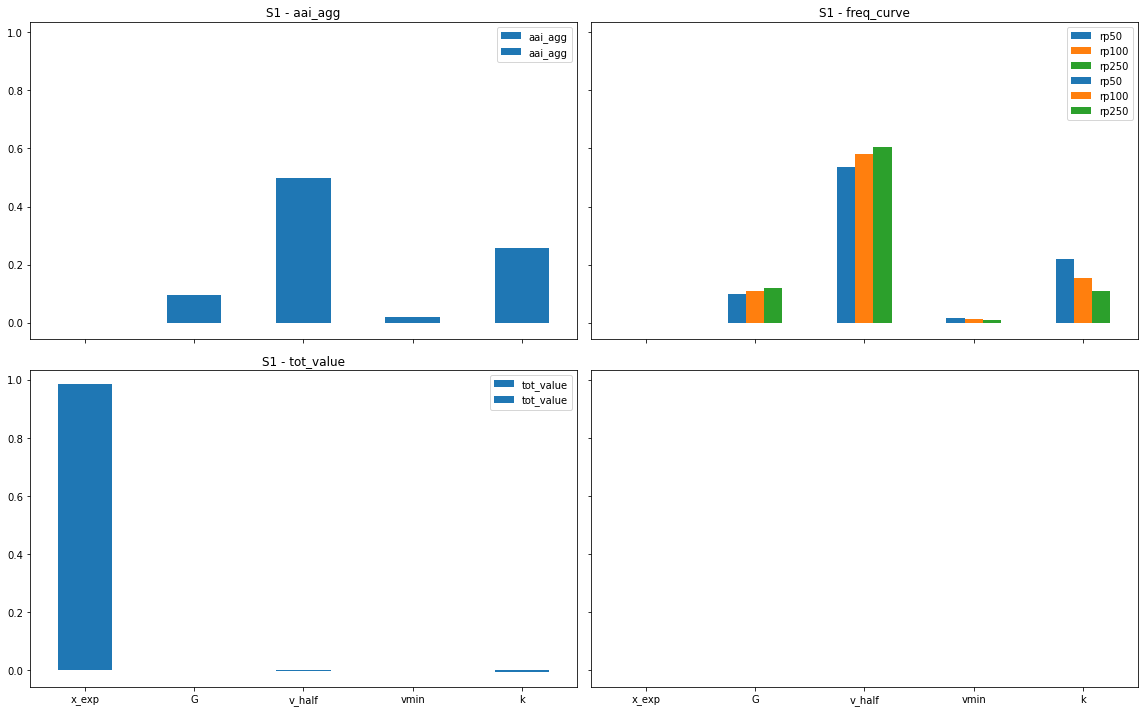

In [27]:
output_imp2.plot_sensitivity();

Since we computed the distribution and sensitivity indices for the total impact at each exposure point, we can plot a map of the largest sensitivity index in each exposure location. This yields a rather suprising result that for every location, the most sensitive parameter is `x_exp`, the exposures scaling parameter.

array([<GeoAxesSubplot:title={'center':'Sensitivity map'}>], dtype=object)

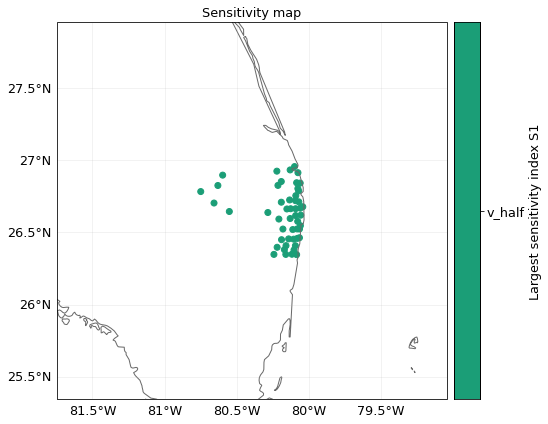

In [28]:
output_imp2.plot_sensitivity_map(exp_base)

## CostBenefit (not yet update to new version of uncertainty module)

The uncertainty and sensitivity analysis for CostBenefit is completely analogous to the Impact case. It is slightly more complex as there are more input variables.

Define the uncvar_func.

In [56]:
import copy
from climada.util.constants import ENT_DEMO_TODAY, ENT_DEMO_FUTURE, HAZ_DEMO_H5
from climada.entity import Entity
from climada.hazard import Hazard

# Entity today has an uncertainty in the total asset value
def ent_today_func(x_ent):
    entity = Entity()
    entity.read_excel(ENT_DEMO_TODAY)
    entity.exposures.ref_year = 2018
    entity.exposures.gdf.value *= x_ent
    return entity

# Entity in the future has a +- 10% uncertainty in the cost of all the adapatation measures
def ent_fut_func(m_fut_cost):
    entity = Entity()
    entity.read_excel(ENT_DEMO_FUTURE)
    entity.exposures.ref_year = 2040  
    for meas in entity.measures.get_measure('TC'):
        meas.cost *= m_fut_cost
    return entity

haz_base = Hazard()
haz_base.read_hdf5(HAZ_DEMO_H5)

# The hazard intensity in the future is also uncertainty by a multiplicative factor
def haz_fut_func(x_haz_fut, haz=haz_base):
    haz = copy.deepcopy(haz_base)
    haz.intensity = haz.intensity.multiply(x_haz_fut)
    return haz


2021-08-23 19:28:13,879 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5


/Users/ckropf/opt/anaconda3/envs/climada_220/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Check that costs for measures are changed as desired.

In [57]:
costs_1 = [meas.cost for meas in ent_fut_func(1).measures.get_measure('TC')]
costs_05 = [meas.cost for meas in ent_fut_func(0.5).measures.get_measure('TC')]
print(f"\nThe cost for m_fut_cost=1 are {costs_1}\n"
     f"The cost for m_fut_cost=0.5 are {costs_05}");


The cost for m_fut_cost=1 are [1311768360.8515418, 1728000000.0, 8878779433.630093, 9200000000.0]
The cost for m_fut_cost=0.5 are [655884180.4257709, 864000000.0, 4439389716.815046, 4600000000.0]


/Users/ckropf/opt/anaconda3/envs/climada_220/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Define the UncVars

In [58]:
import scipy as sp
from climada.engine.uncertainty import UncVar

haz_today = haz_base

haz_fut_distr = {"x_haz_fut": sp.stats.uniform(1, 3),
              }
haz_fut_unc = UncVar(haz_fut_func, haz_fut_distr)

ent_today_distr = {"x_ent":  sp.stats.uniform(0.7, 1)}
ent_today_unc = UncVar(ent_today_func, ent_today_distr)

ent_fut_distr = {"m_fut_cost":  sp.stats.norm(1, 0.1)}
ent_fut_unc = UncVar(ent_fut_func, ent_fut_distr)

ModuleNotFoundError: No module named 'climada.engine.uncertainty'

Initialize the UncCostBenefit object and make a sample with N=10. Set `calc_second_order=False`.

In [ ]:
from climada.engine.uncertainty import UncCostBenefit

unc = UncCostBenefit(haz_unc=haz_today, ent_unc=ent_today_unc,
                     haz_fut_unc=haz_fut_unc, ent_fut_unc=ent_fut_unc)
unc.make_sample(N=10, sampling_kwargs={'calc_second_order':False})

For longer computations, it is possible to use a pool for parallel computation.

In [ ]:
from pathos.pools import ProcessPool as Pool

pool = Pool()
unc.calc_distribution(pool=pool)
pool.close() #Do not forget to close your pool!
pool.join()
pool.clear()

The output of `CostBenefit.calc` is rather complex in its structure. The metrics dictionary inherits this complexity.

In [ ]:
#Top level metrics keys
macro_metrics = list(unc.metrics.keys())
macro_metrics

In [ ]:
# The benefits and the cost_ben_ratio are available for each measuret
print(list(unc.metrics['benefit'].keys()))
print(list(unc.metrics['cost_ben_ratio'].keys()))

In [ ]:
# The impact_meas_present and impact_meas_future provide values of the cost_meas, risk_transf, risk, 
# and cost_ins for each measure
print(list(unc.metrics['imp_meas_present'].keys()))
print(list(unc.metrics['imp_meas_future'].keys()))

We can plot the distributions for the top metrics or our choice.

In [ ]:
# tot_climate_risk and benefit
unc.plot_distribution(metric_list=['tot_climate_risk', 'benefit']);

In [ ]:
# cost benefit ratio
unc.plot_distribution(metric_list=['cost_ben_ratio'] );

Analogously to the impact example, now that we have a metric distribution, we can compute the sensitivity indices. Since we used the default sampling method, we can use the default sensitivity analysis method. However, since we used `calc_second_order = False` for the sampling, we need to specify the same for the sensitivity analysis.

In [ ]:
unc.calc_sensitivity(method_kwargs = {'calc_second_order':False})

The sensitivity indices can be plotted. For the default method 'sobol', by default the 'S1' sensitivity index is plotted.

Note that since we have quite a few measures, the plot must be adjusted a bit or dropped. Also see that for many metrics, the sensitivity to certain uncertainty parameters appears to be 0. However, this result is to be treated with care. Indeed, we used for demonstration purposes a rather too low number of samples, which is indicated by large confidence intervals (vertical black lines) for most sensitivity indices. For a more robust result the analysis should be repeated with more samples.

In [ ]:
axes = unc.plot_sensitivity();

In [ ]:
axes = unc.plot_sensitivity(metric_list=['cost_ben_ratio','tot_climate_risk','benefit']);

## InputVar - built-in methods

The InputVar class provides a few helper methods to generate generic uncertainty input variables for exposures, impact function sets, hazards, and entities (including measures cost and disc rates).

In [ ]:
from climada.engine.uncertainty_quantification import InputVar

**Exposures**

The following types of uncertainties can be added:

- ET: scale the total value (homogeneously)
        The value at each exposure point is multiplied by a number
        sampled uniformly from a distribution with
        (min, max) = bounds_totvalue
- EN: mutliplicative noise (inhomogeneous)
        The value of each exposure point is independently multiplied by
        a random number sampled uniformly from a distribution
        with (min, max) = bounds_noise

If a bounds is None, this parameter is assumed to have no uncertainty.


In [ ]:
#Define the base exposure
from climada.util.constants import EXP_DEMO_H5
from climada.entity import Exposures
exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)

In [ ]:
bounds_totval = [0.9, 1.1] #+- 10% noise on the total exposures value
bounds_noise = [0.9, 1.2] #-10% - +20% noise each exposures point
exp_iv = InputVar.exp(exp_base, bounds_totval, bounds_noise)

In [ ]:
#The difference in total value between the base exposure and the average input uncertainty exposure 
#due to the random noise on each exposures point (the average change in the total value is 1.0).
avg_exp = exp_iv.evaluate()
(sum(avg_exp.gdf['value']) - sum(exp_base.gdf['value'])) / sum(exp_base.gdf['value'])

**Hazard**

The following types of uncertainties can be added:

- HE: sub-sampling events from the total event set
            For each sub-sample, n_ev events are sampled with replacement.
- HI: scale the intensity of all events (homogeneously)
            The instensity of all events is multiplied by a number
            sampled uniformly from a distribution with (min, max) = bounds_int
- HF: scale the frequency of all events (homogeneously)
            The frequency of all events is multiplied by a number
            sampled uniformly from a distribution with (min, max) = bounds_freq

If a bounds is None, this parameter is assumed to have no uncertainty.

In [ ]:
#Define the base exposure
from climada.util.constants import HAZ_DEMO_H5
from climada.hazard import Hazard
haz_base = Hazard()
haz_base.read_hdf5(HAZ_DEMO_H5)

In [ ]:
bounds_freq = [0.9, 1.1] #+- 10% noise on the frequency of all events
bounds_int = None #No uncertainty on the intensity
n_ev = None 
haz_iv = InputVar.haz(haz_base, n_ev=n_ev, bounds_freq=bounds_freq, bounds_int=bounds_int)

In [ ]:
#The difference in frequency for HF=1.1 is indeed 10%.
haz_high_freq = haz_iv.evaluate(HE=n_ev, HI=None, HF = 1.1)
(sum(haz_high_freq.frequency) - sum(haz_base.frequency)) / sum(haz_base.frequency)

In [ ]:
bounds_freq = [0.9, 1.1] #+- 10% noise on the frequency of all events
bounds_int = None #No uncertainty on the intensity
n_ev = round(0.8 * haz_base.size) #sub-sample with re-draw events to obtain hazards with n=0.8*tot_number_events
haz_iv = InputVar.haz(haz_base, n_ev=n_ev, bounds_freq=bounds_freq, bounds_int=bounds_int)

Note that the HE is not a univariate distribution, but for each sample corresponds to the names of the sub-sampled events. However, to simplify the data stream, the HE is saved as if it was from a uniform distribution (0, 1). Hence, the value of HE is only a label for the given sample, but does not reflect the chosen events.

In [ ]:
haz_iv.plot()

The number of events per sub-sample is equal to n_ev

In [ ]:
#The number of events per sample is equal to n_ev
haz_sub = haz_iv.evaluate(HE=0.33, HI=None, HF = 1.1)  #The number for HE is irrelevant
haz_sub.size - n_ev

**ImpactFuncSet**

The following types of uncertainties can be added:
- MDD: scale the mdd (homogeneously)
            The value of mdd at each intensity is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_mdd
- PAA: scale the paa (homogeneously)
            The value of paa at each intensity is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_paa
- IFi: shift the intensity (homogeneously)
            The value intensity are all summed with a random number
            sampled uniformly from a distribution with
            (min, max) = bounds_int

If a bounds is None, this parameter is assumed to have no uncertainty.

In [ ]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone
impf = ImpfTropCyclone()
impf.set_emanuel_usa()
impf_set_base = ImpactFuncSet()
impf_set_base.append(impf)

It is necessary to specify the hazard type and the impact function id. For simplicity, the default uncertainty input variable only looks at the uncertainty on one single impact function.

In [ ]:
bounds_impfi = [-10, 10] #-10 m/s ; +10m/s uncertainty on the intensity
bounds_mdd = [0.7, 1.1] #-30% - +10% uncertainty on the mdd
bounds_paa = None #No uncertainty in the paa
impf_iv = InputVar.impfset(impf_set_base,
                           bounds_impfi=bounds_impfi,
                           bounds_mdd=bounds_mdd,
                           bounds_paa=bounds_paa,
                           haz_type='TC',
                           fun_id=1)

In [ ]:
#Plot the impact function for 50 random samples (note for the expert, these are not global)
n = 50
ax = impf_iv.evaluate().plot()
inten = impf_iv.distr_dict['IFi'].rvs(size=n)
mdd = impf_iv.distr_dict['MDD'].rvs(size=n)
for i, m in zip(inten, mdd):
    impf_iv.evaluate(IFi=i, MDD=m).plot(axis=ax)
ax.get_legend().remove()

**Entity**


The following types of uncertainties can be added:
- DR: scale the discount rates (homogeneously)
            The value of the discounts in each year is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_disc
- CO: scale the cost (homogeneously)
            The cost of all measures is multiplied by the same number
            sampled uniformly from a distribution with
            (min, max) = bounds_cost
- ET: scale the total value (homogeneously)
            The value at each exposure point is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_totvalue
- EN: mutliplicative noise (inhomogeneous)
            The value of each exposure point is independently multiplied by
            a random number sampled uniformly from a distribution
            with (min, max) = bounds_noise
- MDD: scale the mdd (homogeneously)
            The value of mdd at each intensity is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_mdd
- PAA: scale the paa (homogeneously)
            The value of paa at each intensity is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_paa
- IFi: shift the intensity (homogeneously)
            The value intensity are all summed with a random number
            sampled uniformly from a distribution with
            (min, max) = bounds_int


If a bounds is None, this parameter is assumed to have no uncertainty.


**Entity Future**

The following types of uncertainties can be added:
- CO: scale the cost (homogeneously)
            The cost of all measures is multiplied by the same number
            sampled uniformly from a distribution with
            (min, max) = bounds_cost
- EG: scale the exposures growth (homogeneously)
            The value at each exposure point is multiplied by a number
            sampled uniformly from a distribution with
- EN: mutliplicative noise (inhomogeneous)
            The value of each exposure point is independently multiplied by
            a random number sampled uniformly from a distribution
            with (min, max) = bounds_noise
- MDD: scale the mdd (homogeneously)
            The value of mdd at each intensity is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_mdd
- PAA: scale the paa (homogeneously)
            The value of paa at each intensity is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_paa
- IFi: shift the impact function intensity (homogeneously)
            The value intensity are all summed with a random number
            sampled uniformly from a distribution with
            (min, max) = bounds_impfi


If a bounds is None, this parameter is assumed to have no uncertainty.